# Solution - Computational Modeling Exercise

**Author** - Daniel Rothenberg (darothen@mit.edu)

**Date** - January 30, 2017

This is a reference solution for the **12.806 Computational Modeling Exercise**, including versions of required and suggested figures for reference and all code used to produce the solution. This solution was implemented in Python using wildly-popular scientific and numerical libraries. 

For convenience, we'll use two very powerful Python libraries:

- [Numpy](http://www.numpy.org) - a numerical framework for Python centered around an $n$-dimensional array object; includes many useful mathematical functions.
- [pandas](http://pandas.pydata.org/) - an analysis package based on data tables; allows you to quickly organize tabular data and run common statistics and analysis on them.

In [1]:
import numpy as np
import pandas as pd

Additionally, we'll need to generate some plots, so we'll use the standard Python visualization libraries:

- [matplotlib](http://matplotlib.org) - Matlab-like visualization library
- [seaborn](http://stanford.edu/~mwaskom/software/seaborn/) - extension to matplotlib which generates quick statistical plots when data is packaged into pandas data structures; additionally includes aesthetic tweaks which greatly improve the matplotlib basics

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
# Set some plot aesthetics
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

Finally, to read the Excel spreadsheet data source in the final part of this notebook, you'll need the [xlrd](https://xlrd.readthedocs.io/en/latest/) package, which you can install by invoking:

``` shell
$ pip install xlrd
```

### Part 1 | Contemporary Trends in Atmospheric C)$_2$

We'll start by downloading the monthly mean CO$_2$ data, using a shell command in the cell below.

In [4]:
!wget ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt .

--2017-01-30 14:27:52--  ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt
           => ‘co2_mm_mlo.txt’
Resolving aftp.cmdl.noaa.gov... 140.172.200.31
Connecting to aftp.cmdl.noaa.gov|140.172.200.31|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /products/trends/co2 ... done.
==> SIZE co2_mm_mlo.txt ... 49083
==> PASV ... done.    ==> RETR co2_mm_mlo.txt ... done.
Length: 49083 (48K) (unauthoritative)

100%[======================================>] 49,083       223KB/s   in 0.2s   

2017-01-30 14:27:54 (223 KB/s) - ‘co2_mm_mlo.txt’ saved [49083]

--2017-01-30 14:27:54--  http://./
Resolving .... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘.’
FINISHED --2017-01-30 14:27:54--
Total wall clock time: 2.6s
Downloaded: 1 files, 48K in 0.2s (223 KB/s)


Read in the table using Pandas' I/O functions. We'll independently supply column names and have it automatically sniff out the appropriate whitespace separation between columns. Furthermore, we'll mask missing values, and construct a pivot-table broken down into a multi-index based on year and month (which will be useful later on for analysis). Note that we didn't need to delete the original metadata header to the input data - using the **comment** argument to `read_table()`, we can instruct Pandas to ignore those lines.

In [6]:
mauna_loa = pd.read_table("co2_mm_mlo.txt", header=None,
                          names=["year", "month", "decimal_date",
                                 "average", "interpolated",
                                 "trend_seas_corr", "missing_days"],
                          delim_whitespace=True, na_values=[-99.99],
                          comment="#")

mauna_loa_pt = pd.pivot_table(mauna_loa, index=['year', 'month'])
year_groups = mauna_loa.groupby('year')
mauna_loa_yearly = year_groups.aggregate(np.mean)

From the data, we'll plot the monthly mean data alongside yearly-mean data that we've computed by aggregated and averaging the pivot-table data by year. Note that we shift the index of the yearly data by half of a year, just for plotting purposes (so it lines up with the middle of the year).

We'll wrap the plotting mechanics in its own function so that we can use this as a base for future plots with additional analysis later on.

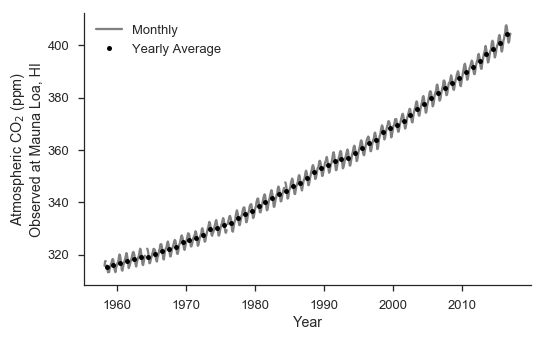

In [7]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

def mauna_loa_plot(ax):
    """ Wrapper for basic Mauna Loa plot, so we can plot additional 
    curves later on """
    
    ax.plot(mauna_loa.decimal_date, mauna_loa.average,
            '-', color='grey', label="Monthly")
    ax.plot(mauna_loa_yearly.index + 0.5, mauna_loa_yearly.average,
            'ok', ms=5, label='Yearly Average')

    ax.legend(loc='upper left')
    ax.set_xlabel("Year")
    ax.set_ylabel("Atmospheric CO$_2$ (ppm)\nObserved at Mauna Loa, HI")
    sns.despine()
    
    return ax

ax = mauna_loa_plot(ax)

Now we need to generate polynomial fits to the data. In other terms, we want to compute the coefficients in equations like $$P_1(t) = a + bt$$ and $$P_2(t) = a + bt + ct^2$$ such that we minimize the residual between the estimated data and the observations, $$\sum\limits_{i=1}^n\big|P_i(t_i) - y(t_i)\big|$$

For the polynomials, we can use the built-in `polyfit` and `poly1d` tools from NumPy, which will take care of setting up the polynomials and evaluating them based on the resulting coefficients we compute. However, for the exponential fit, we'll use a helper function from SciPy's `optimize` package called `curve_fit`, which allows us to define an arbitrary functional form. The package will take care of the non-linear least squares fitting (done via Levenberg-Marquardt in this case). Note that we could alternatively take the logarithm of the exponential fit, which produces a linear equation we can fit using traditional least-squares.

First order -
 
1.524 x - 2677
Second order -
        2
0.0124 x - 47.77 x + 4.63e+04
Exponential -
2.56e+02 + 5.76e+01 exp(-1.62e-02*(t - 1850))


/Users/daniel/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp


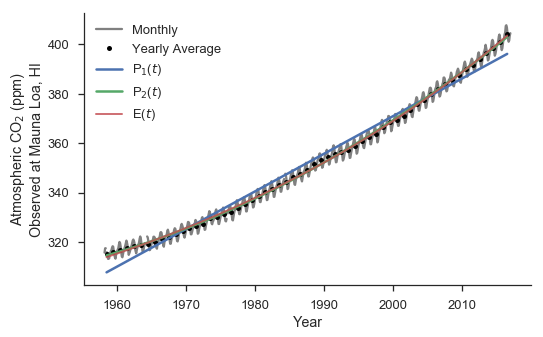

In [8]:
xi = mauna_loa_yearly.index + 0.5
yi = mauna_loa_yearly.average

## 1st degree
p_1 = np.poly1d( np.polyfit(xi, yi, 1) )
print "First order -"
print p_1

## 2nd degree
p_2 = np.poly1d( np.polyfit(xi, yi, 2) )
print "Second order -"
print p_2

## Exponential
from scipy.optimize import curve_fit
def exp_func(x, a, b, c):
    x_off = x - xi[0] # we re-base x at 0 for numerical
                      # purposes
    return a + b*np.exp(-c*x_off)
coeff_opt, pcov = curve_fit(exp_func, xi, yi)
exf = lambda x: exp_func(x, *coeff_opt)
print "Exponential -"
print "{0:.2e} + {1:.2e} exp({2:+.2e}*(t - 1850))".format(*coeff_opt)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

mauna_loa_plot(ax)
ax.plot(xi, p_1(xi), lw=2.5, label="P$_1$($t$)")
ax.plot(xi, p_2(xi), lw=2.5, label="P$_2$($t$)")
ax.plot(xi, exf(xi), lw=2,
        label="E($t$)", alpha=.8)
ax.legend(loc='upper left')

Let's de-trend the data using the 2nd-order polynomial $P_2(t)$, which produces a rather good fit. Then, we'll average the seasonal cycle in terms of an anomaly for each decade using a split-apply-combine operation, and then plot the annual cycle for each decade.

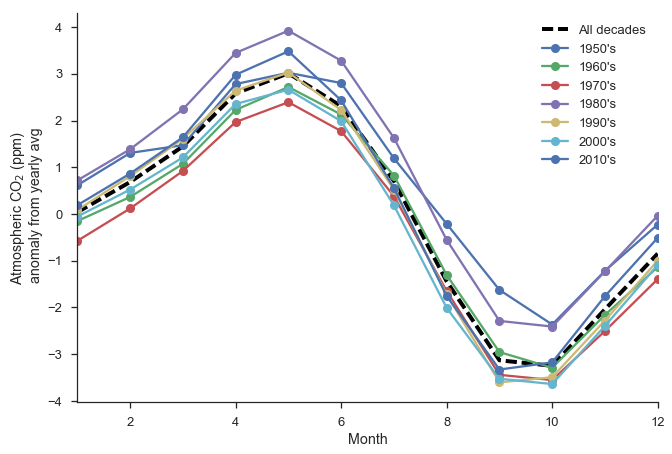

In [9]:
mauna_loa['average_detrend'] = \
    mauna_loa['average'] - p_2(mauna_loa['decimal_date'])
mauna_loa['decade'] = \
    np.floor((mauna_loa['year'] - 1900)/10.)

monthly = mauna_loa.groupby('month')
ml_mo_cycle = monthly.aggregate(np.mean)
plt.plot(ml_mo_cycle.index, ml_mo_cycle['average_detrend'],
         '--k', label='All decades', lw=4)
    
decade_groups = mauna_loa.groupby(['decade', 'month'])
ml_dec_cycle = decade_groups.aggregate(np.mean)

decades = ml_dec_cycle.index.levels[0]
for decade in decades:
    ml_dec = ml_dec_cycle.loc[decade]
    plt.plot(ml_dec.index, ml_dec['average_detrend'],
             marker='o', label="%4d's" % (1900+decade*10,))
    
plt.legend(loc='upper right')
plt.xlim(1, 12)
plt.xlabel('Month')
plt.ylabel('Atmospheric CO$_2$ (ppm)\n anomaly from yearly avg')
    
sns.despine()

The above calculation gives a peak into how powerful Pandas (and similar libraries) are. The first two lines of the above cell respectively (1) de-trend the data, and (2) calculate what decade a given value takes place in. Then, we go on to group all the data with like decades together, then with like months in each decade, and compute our analysis that way. If we were more clever, we could've assigned a `datetime`-like index and automatically inferred these values from that. It's worthwhile using these sorts of libraries whenever you're doing timeseries analysis!

Just as a reference, suppose we did not have the nifty timeseries and analysis capabilities of a package like Pandas. We could still easily compute the seasonal cycles above, although we'd have to focus our efforts on keeping track of indices inside a big array. Let's do that, focusing on computing the average seasonal anomaly cycle over all the years in the dataset.

Note that we have to do a little bit of index magic to make sure that we sort the right month into the right place in the array holding the results. Not unbearable, but the Pandas solution is easier and takes all of this into account already.

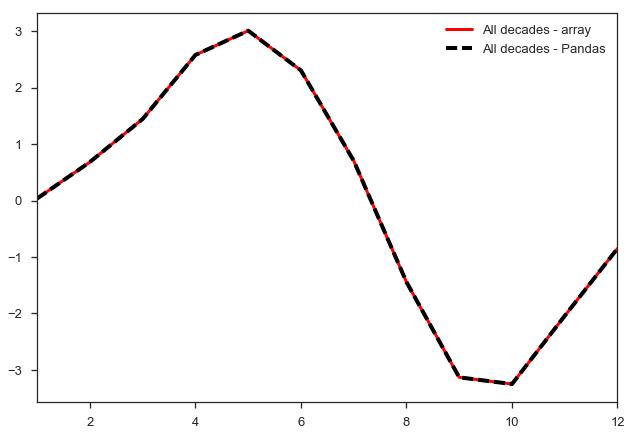

In [11]:
data = mauna_loa.average_detrend[:]
year0  = mauna_loa.year.ix[0]
month0 = mauna_loa.month.ix[0]

monthly_average = np.zeros(12)
for month in xrange(12):
    monthly_data = data[month::12] # take every 12th element, starting 
                                   # at the month we're on
    # Carefully arrange the averages into the proper
    # index in `monthly_average`, based on what the 
    # first month in the dataset is
    idx = (month + month0) 
    if idx >= 12: 
        idx = idx - 12 # You can also say 'idx -= 12', but that's not very 
                       # Pythonic
    monthly_average[idx-1] = np.mean(monthly_data)
    #print month, idx, np.mean(monthly_data)
    
plt.plot(range(1, 13), monthly_average, '-r', 
         label="All decades - array", lw=3) 
plt.plot(ml_mo_cycle.index, ml_mo_cycle['average_detrend'],
         '--k', label='All decades - Pandas', lw=4)
plt.xlim(1, 12)
plt.legend(loc='upper right')

We can now combine the two procedures. In general, if we were fitting some sort of functional model to a complex set of data, we might want to first decompose the model and the data into two separate functions. Then, we could take the linear combination of the two and call that our predictor model. We've implicitly done that already, here, by breaking down the model into a long-term component (the polynomial fits to the yearly data) and a seasonal anomaly on top of the trend. 

We can formalize this approach by fitting a sine curve of the form $$y(t) \approx \sum\limits_{k=1}^nA_k \sin \frac{2\pi k}{T_k}(t + \phi_k)$$ where $A$, $T$, and $\phi$ are the parameters of interest. Let's fit the seasonal cycle in this way, and try to model the long-term CO$_2$ record using the combination of the long-term and sesonal components.

*Note* - We've normalized the month in decimal form at the center of the month (1/12 - 1/24). You don't necessarily have to do this, but it's something to pay attention for later on.

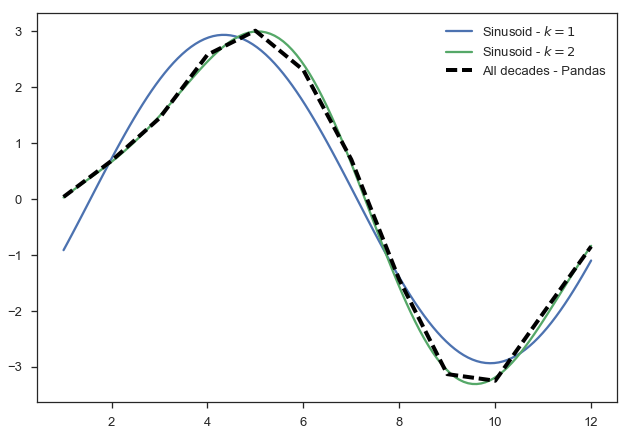

In [12]:
## Drop NaNs from the data since it messes up the
## numerical routines
ml_proc = mauna_loa.dropna()

xi = ml_proc.month
xi = (xi/12.) - (1./24.)
yi = ml_proc.average_detrend

def sin_func_1(x, A, T, phi):
    return A*np.sin((2.*np.pi/T)*(x + phi))
sin_comps_1, _ = curve_fit(sin_func_1, xi, yi)
sin1 = lambda x: sin_func_1(x, *sin_comps_1)

def sin_func_2(x, A1, A2, T1, T2, phi1, phi2):
    return A1*np.sin((2.*np.pi/T1)*(x + phi1)) \
         + A2*np.sin((2.*np.pi/T2)*(x + phi2))
sin_comps_2, _ = curve_fit(sin_func_2, xi, yi)
sin2 = lambda x: sin_func_2(x, *sin_comps_2)

xs = np.linspace(1., 12., 121)
xs_norm = xs/12. - 1./24.
ys1 = sin1(xs_norm)
ys2 = sin2(xs_norm)
plt.plot(xs, ys1, label="Sinusoid - $k=1$")
plt.plot(xs, ys2, label="Sinusoid - $k=2$")
plt.plot(ml_mo_cycle.index, ml_mo_cycle['average_detrend'],
         '--k', label='All decades - Pandas', lw=4)

plt.legend()


It's straightforward to now combine the long-term trend and the seasonal cycle. We can write a wrapper function to automate the combination for us, and do all the mathemagics that must happen (e.g. month normalizaton, etc)

/Users/daniel/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
/Users/daniel/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in multiply


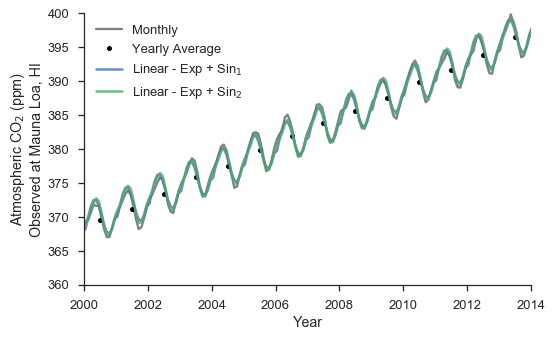

In [13]:
ml_proc = mauna_loa.dropna()
xi = ml_proc.decimal_date.values[:]
yi = ml_proc.average[:]

## Re-do the exponential fit
def exp_func(x, a, b, c):
    x_off = x - xi[0] # we re-base x at 0 for numerical
                      # purposes
    return a + b*np.exp(-c*x_off)
coeff_opt, pcov = curve_fit(exp_func, xi, yi)
exf = lambda x: exp_func(x, *coeff_opt)

def combo(x, k=2):
    # Extract the month in decimal form
    month = x - np.floor(x)
    
    long_term = exf(x)
    if k == 1:
        seasonal = sin1(month)
    elif k == 2:
        seasonal = sin2(month)
    else:
        raise ValueError("k = %d not yet defined" % k)    

    return long_term + seasonal

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

mauna_loa_plot(ax)
ys = [combo(xsi, 1) for xsi in xi]
ax.plot(xi, ys, lw=2.5, label="Linear - Exp + Sin$_1$",
        alpha=0.8)
ys = [combo(xsi, 2) for xsi in xi]
ax.plot(xi, ys, lw=2.5, label="Linear - Exp + Sin$_2$",
        alpha=0.8)
plt.xlim(2000, 2014)
plt.ylim(360, 400)
ax.legend(loc='upper left')

We're actually reproducing things incredibly well; we only ever miss out on some peaks to the seasonal cycle (for example in 2002). Of course, we'd need to do some rigorous statistical analysis beyond this to validate that the model isn't just an overfit. But the general steps we used to break down the various components could certainly be repeated elsewhere.

---

### Part 2 | Compartmental Model of the Global Carbon Cycle

The model was implemented separately (see the appendices). Your mileage may vary in the following portion of the exercise, but in general I'd recommend wrapping your model so that it only takes 1-2 lines of code to initialize the model and then run it, returning all the output you need to analyze the results.

#### 2.1 - Problem 1

In the framework of a simple box-model like the one we've written here, one can analyze the lifetime of species in each reservoir by collecting the all the sources and sinks and re-writing the equation in the form

$$\frac{dC}{dt} = \text{Sources} - \text{Sinks}$$

where "Sources" and "Sinks" are all positive and negative terms, respectively, in the original system of ODEs. Neglecting the source term and considering the fact that most of the sinks are going to be represented in the form $k_i X$, we can represent the lifetime as 

$$\tau = \frac{X}{\sum\limits_{i=1}^n k_i}$$

$k_i$ is, in our case, each of the arrows leading *away* from a given reservoir in Figure 22.6 of Seinfeld and Pandis. This formula yields the following lifetimes for each reservoir:

In [14]:
from IPython.display import Latex, display

reservoirs = {
    # name -> [amount (PgC), removal rate (PgC/yr)
    'M1': [612., 100. + 57. + 19],
    'M2': [730., 12. + 57. + 58.],
    'M3': [140., 100. + 18.],
    'M4': [37000., 40. + 70.],
    'M5': [580., 50. + 50.],
    'M6': [1500., 50.],
}


format_str = r"$\tau$(M$_{n:1d}$) = {tau:>5.1f} years"
for n in xrange(1, 7):
    [X, ks] = reservoirs['M%1d' % n]
    k = np.sum(ks)
    tau = X/ks
    display(Latex(format_str.format(n=int(n), tau=tau)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### 2.1 - Problem 2

There are two different surface ocean reservoirs because the equilibrium dissolution of $\ce{CO2}$ in seawater is dependent on the water's temperature and pH.

$\ce{CO2}$ hydrolizes when it disolves in seawater:

\\[ \begin{align*} \cee{CO2(g) + H2O &<=> CO2.H2O} \\ \cee{CO2.H2O & <=> H+ + HCO3-} \\ \cee{HCO3- &<=> H+ + CO3^{2-}} \end{align*} \\]

This produces both carbonate and bicarbonate ions. The abundance of dissolved salts in the ocean affects pH locally between a range of about 7.5 and 8.4, which is further impacted by temperature. Also, this reaction system is buffered; as $\ce{CO2}$ dissolves in seawater, that reservoir can take up less and less $\ce{CO2}$ from the atmosphere. The complexity of this reaction sequence is simplified in the compartmental model using a simple parameterization developed by [Ver et al (1999)](http://earth.geology.yale.edu/~ajs/1999/07-09.1999.11Ver.pdf), which modifies the loss mechanism of atmospheric $\ce{CO2}$ via dissolution in seawater as $F = kM^\beta$, where $\beta$ is a positive constant which accounts for this complex chemistry. Using the two reservoirs and suitable associated $\beta$'s, the compartmental model can attempt to simulate oceanic carbon sink.

---

#### 2.1 - Problem 3

Assume that all the carbon in the atmosphere is present in the form of $\ce{CO2}$. The (volume) mixing ratio of a gas in the air is given as the ratio of a trace constituents molar concentration to that of the full gas. Note that this is a useful quantity to know because as the density of the air changes, the mixing ratio will remain the same, so one can always back out the mass of a given trace constituent with minimal extra information.

To a good approximation, the mean molecular weight of air can be computed just from the relative abundance and molecular weights of $\ce{N2}$, $\ce{O2}$, and $\ce{Ar}$ (which total 99.3% of the atmosphere by mass or volume):

\\[M_a = (0.78\cdot28\text{g/mol}) + (0.21\cdot32\text{g/mol}) + (0.01\cdot40\text{g/mol}) \approx 28.97\text{g/mol}\\]

(note that we rounded up the abundance of argon). 

The molar mass of carbon is 12.01 g/mol; it's just about 16 g/mol for elemental oxygen, so carbon dioxide has a molar mass of 44.01 g/mol. If the pre-industrial atmospheric carbon burden was 612 Pg, then we can multiply by the molar ratio of carbon to carbon dioxide to yield the mass of $\ce{CO2}$ in the atmosphere, 

\\[ \text{Mass($\ce{CO2}$)} = 612\text{ Pg(C)} * \frac{44.01 \text{ g($\ce{CO2})$/mol}}{12.01 \text{ g(C)/mol}} = 2244 \text{ Pg($\ce{CO2}$)} \\]

Since we know the mass of the atmosphere is roughly $5.15\times10^{18}$ kg, the mass mixing ratio of $\ce{CO2}$ is just

\\[ r(\ce{CO2}) = \frac{224.3\text{ Pg}}{5.15\times10^{18}\text{ kg}} = 435.73 \text{ ppm(m)} \\]

To convert equivalently between mass mixing ratio and molar/volume mixing ratio, we have to account for difference in number concentrations of the molecules of each constituent, which are going to differ because they have molar mass. However, this computation can be radically shortened by noting that the mass mixing ratio is approximately equal to the molar mixing ratio times the ratio of the molar weight of the trace gas to the average molar weight of the entire gas, 

\\[ \chi(\ce{X})\frac{M(\text{X})}{M_a} = \text{r(X)} \\]

Substituting in our intermediate values, we get

\\[ \chi(\ce{CO2}) = 435.73 \text{ ppm(m)} \times \frac{28.97\text{ g/mol}}{44.01\text{ g/mol}} \approx  286.8 \text{ ppm(v)}\\]

which is a very reasonable estimate for pre-industrial $\ce{CO2}$ based on numerous proxy records.

---

### Numerical methods

I've implemented the model and integrators in Python (see the attached appendix). Note that I've wrapped the model using objects and classes to make my code easier to write and use - your mileage may vary on this front. But at the end of the day, your model should consist of two components:

1. An implementation of the right-hand side of the governing system of ODEs

2. An implementation of the integration/marching algorithm

The latter could be trivially simple. For instance, here is an implementation of the marching code using Euler's method:

``` python
def integrate(self, func, y0, t):

    out_y = [np.asarray(y0), ]
    
    for i, ti in enumerate(t[:-1]):
        y = out_y[-1]
        delta_t = t[i+1] - ti
        new_y = y + delta_t*func(y, ti)
        out_y.append(new_y)
        
    return np.array(out_y)
```

The code merely evaluates the RHS equation (implemented by `func`) at each output instant and uses that to march forward in time.

I've written my code in a simple object-oriented framework, and attached it as appendices to this solution writeup. In the next cell, we execute the model code so that we can re-use it. In general, this sort of framework makes life a lot easier, because we can simply run the model with two or three lines of code, rather than have a messy for-loop and intermediate variable re-definition every single time we wish to run it.

In [15]:
## For convenience, run the integrator/model file rather than 
## import them to overload definitions
%run integrator.py
%run carbon_model.py

First, let's look at the time-dependent emissions input, which we chose to be

\begin{align*}
    F_r(t) &= 0 & \\
    F_d(t) &= 0.3+0.01t,\; \text{($t = 0$ for 1850)} \\
    F_f(t) &= 
        \begin{cases}
            0.014t & \text{from 1850 to 1950 ($t = 0$ for 1850}) \\
            1.4 + (4.6/40)t & \text{from 1950 to 1990 ($t = 0$ for 1850})
        \end{cases}
\end{align*}

This produces a time-varying emissions like,

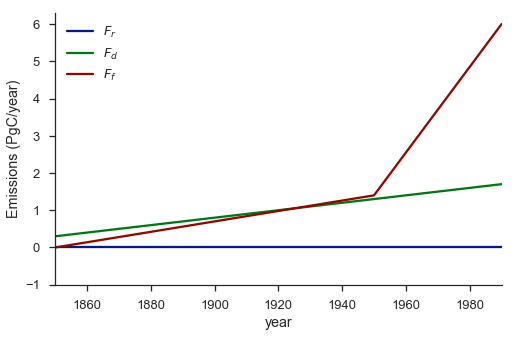

In [16]:
t0, t_end = 1850, 1990
t = np.linspace(0, t_end - t0, t_end - t0 + 1)

## Vectorize the emissions function so we can quickly compute
## emissions for an array of times
emis_vec = np.vectorize(emissions_22p6)
Fr, Fd, Ff = emis_vec(t)

with sns.color_palette("dark"):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    ax.plot(t+t0, Fr, label="$F_r$")
    ax.plot(t+t0, Fd, label="$F_d$")
    ax.plot(t+t0, Ff, label="$F_f$")

ax.set_ylim(-1)
ax.set_xlim(t0, t_end)

sns.despine()
ax.legend(loc='upper left')
ax.set_xlabel("year")
ax.set_ylabel("Emissions (PgC/year)")

So clearly there is a big step up in fossil fuel emissions at 1950. We should think about this information when we evaluate our model's output - something should seriously change after 1950. 

Reference the appendix for implementations of the solvers/marching algorithms. We'll go ahead and integrate the model using them all. Additionally, we'll use SciPy's [`odeint`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) wrapper as a reference solution. `odeint` wraps the industry standard LSODA algorithm via a package called [ODEPACK - an old, Fortran-based library of ODE solvers](http://people.sc.fsu.edu/~jburkardt/f77_src/odepack/odepack.html). Specifically, LSODA uses a system's jacobian to more efficiently march forward in time within specified error and tolerance parameters. In cases where the user can define the time-dependent jacobian of a system they wish to solve, the method is particularly efficient - although it can approximate the jacobian with repeatd calls to the RHS if necessary. Furthermore, LSODA applies heuristics to the jacobian to analyze a system's stiffness, and can automatically switch between a stiff and non-stiff method based on where it can yield the most efficiency. 


Below, we evaluate the model run with each of our numerical methods and the reference one. I'll annotate the code for the reference solution so it's clear what's happenening.

Euler - custom
Heun - custom
RK4 - custom


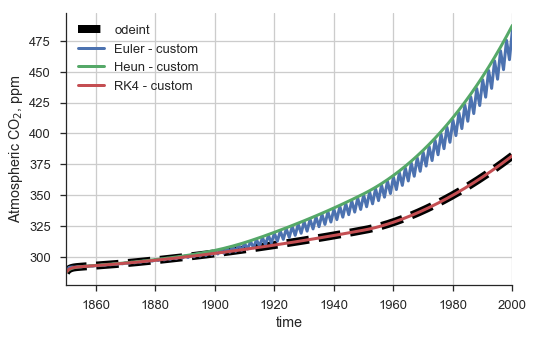

In [19]:
from scipy.integrate import odeint

# Record the initial conditions in an array
y0 = np.array([612, 730, 140, 37000, 580, 1500, 5300, 1.0])

# Define a custom emissions function. Here, we use one defined
# in the appending in carbon_model.py, and we over-ride its
# arguments such that the "switch" time when emissions turn on
# occurs 100 years into the simulation. We've assumed that the
# simulation will start at 1850, as per the documentation for the
# emissions function.
emis_func = lambda t: emissions_22p6(t, 100.)

# Instantiate the model. Note that we 'unpack' the initial condition
# array, to be consistent with the constructor for the model. We also
# explicitly pass the emissions function we just created.
model = CarbonModel(*y0, emis_func=emis_func)

# Some matplotlib commands to create a canvas for plotting.
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

# Integrate the model using the `odeint` method, for 150. years. 
output = model.integrate(odeint, 150.)

# Plot the output, setting some styles for its curve.
output['atm_ppm'].plot(ax=ax, style='--k', label="odeint",
                       lw=8)
plt.xlim(1850, 1959)

# We'll now repeat these steps using other numerical method interfaces.
with sns.color_palette("Paired"):

    print "Euler - custom"
    e = EulerIntegrator()
    o_eu_cust = model.integrate(e, 150., dt=1.)
    o_eu_cust.atm_ppm.plot(ax=ax, lw=3,
                           linestyle='solid', label="Euler - custom")
    print "Heun - custom"
    h = HeunIntegrator()
    o_eu_cust = model.integrate(h, 150., dt=1.)
    o_eu_cust.atm_ppm.plot(ax=ax, lw=3,
                           linestyle='solid', label="Heun - custom")
    print "RK4 - custom"
    r = RK4Integrator()
    o_rk4_cust = model.integrate(r, 150., dt=1.)
    o_rk4_cust.atm_ppm.plot(ax=ax, lw=3,
                            linestyle='solid', label="RK4 - custom")
ax.set_ylabel("Atmospheric CO$_2$, ppm")
plt.legend(loc='upper left')
plt.grid()
sns.despine()

There are a few things to note on this plot.

First, only the Euler solution has an oscillating component in its projection of atmospheric CO$_2$ like we saw in the Mauna Loa data. However, is that a good thing? In this case, no - our model *shouldn't have that feature in its output*! If you inspect the model governing equations, you'll note that there is no component that should feature a seasonal signal. So this must be a deficiency in the solver. We might be able to eliminate it with a smaller timestep.

On the other hand, the RK4 solution at the same timestep converges to the reference solution. This is why it's important to know the limitations of your numerical methods and to have a good way to dial into a known solution!

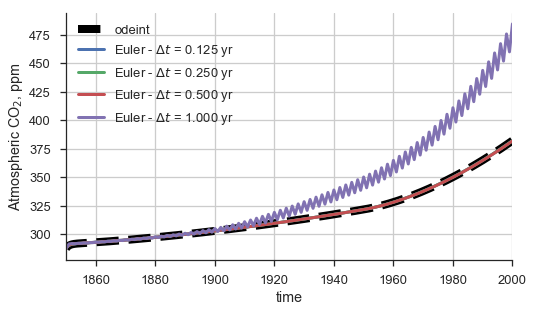

In [22]:
sns.set_palette("deep")
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)

output = model.integrate(odeint, 150.)
ref = lambda x : np.interp(x, output.index, output.atm_ppm)
output['atm_ppm'].plot(ax=ax, style='--k', label="odeint",
                       lw=8)
plt.xlim(1850, 1959)
 
e = EulerIntegrator()
for dt in [1., 0.5, 0.25, 0.125][::-1]:   
    label = "Euler - $\Delta t$ = %1.3f yr" % dt
    o = model.integrate(e, 150., dt=dt)
    o.atm_ppm.plot(ax=ax, label=label, lw=3)
ax.set_ylabel("Atmospheric CO$_2$, ppm")
ax.legend(loc='upper left')
ax.grid()
sns.despine(fig)

That seems to be the case - even halving the timestep is enough to dramatically improve the solution.

Heun's Rule produces a similar issue, except without the oscillatory behavior. Reducing the timestep helps in that case, too:

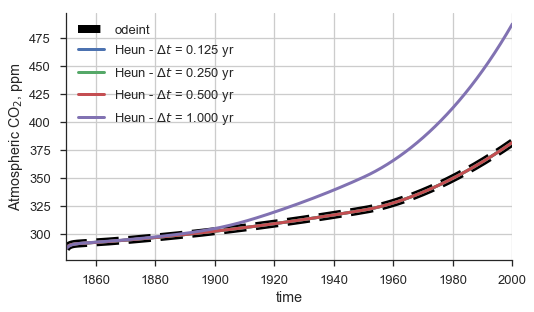

In [23]:
sns.set_palette("deep")
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)

output = model.integrate(odeint, 150.)
ref = lambda x : np.interp(x, output.index, output.atm_ppm)
output['atm_ppm'].plot(ax=ax, style='--k', label="odeint",
                       lw=8)
plt.xlim(1850, 1959)
 
h = HeunIntegrator()
for dt in [1., 0.5, 0.25, 0.125][::-1]:   
    label = "Heun - $\Delta t$ = %1.3f yr" % dt
    o = model.integrate(h, 150., dt=dt)
    o.atm_ppm.plot(ax=ax, label=label, lw=3)
ax.set_ylabel("Atmospheric CO$_2$, ppm")
ax.legend(loc='upper left')
ax.grid()
sns.despine(fig)

---

Let's use the RK4 implementation to find when CO2 doubles. We can naively do this by running our model for a longer period of time and inspecting the solution. Then, to get a numerical estimate, we can interpolate the model solution so that we have the atmospheric CO$_2$ as a smooth function of time. We can use simple root-finding methods like bisection or Newton-Raphson to then find the point where it doubles.

CO2 doubles to 575 ppm in 2070


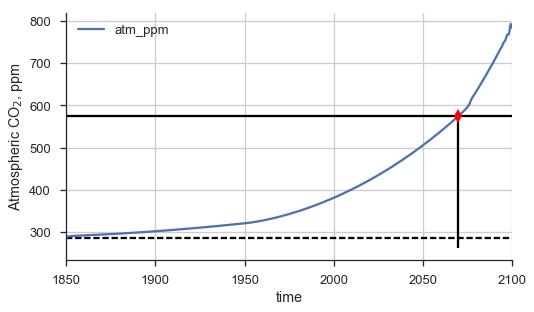

In [24]:
sns.set_palette("deep")
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)

plt.xlim(1850)
 
r = RK4Integrator()
o = model.integrate(r, 250., dt=dt)
o.atm_ppm.plot(ax=ax)
    
ax.set_ylabel("Atmospheric CO$_2$, ppm")
ax.legend(loc='upper left')
ax.grid()
sns.despine(fig)

CO2_0 = o.atm_ppm.iloc[0]
CO2_double = 2.*CO2_0
ax.hlines([CO2_0, CO2_double], 1850, 1850+250,
          linestyles=['dashed', 'solid'])

## Doubling calculation
co2_inc = lambda x : np.interp(x, o.index, o.atm_ppm) - CO2_double
from scipy.optimize import newton
x_dbl = newton(co2_inc, 2000.)

ax.plot(x_dbl, CO2_double, "dr", ms=10)
ax.vlines(x_dbl, ax.get_ylim()[0], CO2_double)

print "CO2 doubles to {amt:3.0f} ppm in {yr:4.0f}"\
    .format(amt=CO2_double, yr=x_dbl)

The CO$_2$ level doubles in 2070, so after about 180 years given the emissions scenario we used.

Alternatively, we could've implemented additional logic in our solver which would terminate the simulation once a specific ending condition was met (our doubling of CO$_2$. In some cases, this is easy to do - for instance, some packages straightforwardly implement this into the integration routine logic they offer. Other times it may not be possible. Hence, the strategy we use here is probably the best bet - run the model for a long time, interpolate the output, and then perform your analysis. This is going to be far more efficient than running the model many times!

---

Suppose the world commits to decreasing its emissions in 2050. We'll model this scenario using an exponentially decaying emissions function which will kick in after some point. Assume the peak emissions occur in 2050 and save that value as $\mathbf{F}_{2050}$ (where all three components of the emissions are rolled into one vector). Then, we can write the emissions as $$ \mathbf{F}(t) = \mathbf{F}_{2050}\exp\left(-\frac{t-2050}{\lambda}\right),\quad t > 2050$$ where $\lambda$ is the e-folding constant, in years. 

The easiest way to encode this emissions logic would be to wrap out original emissions function in a logical block which figures out which regime we're in. If it's before 2050, then it would spit back the original emissions values; if not, then it would return the time-decaying ones. We can write that function and visualize the emissions trace as a function of time:

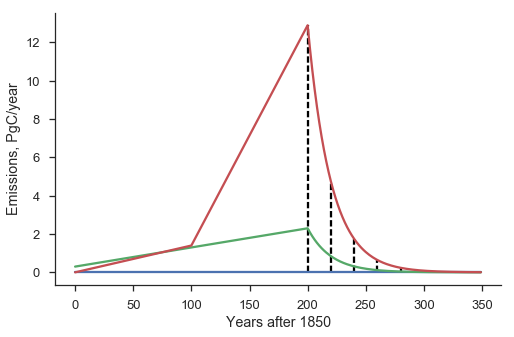

In [25]:
def cust_emis(t, t_off=2050, t0=1850, lam=20.):
    """ t=0 corresponds to t0 """
    emis_ref = emissions_22p6(t)
    if t <= t_off - t0:
        return emis_ref
    else:
        E_2050 = np.array(emissions_22p6((t_off - t0)))
        # Swap the following lines to force the 
        # de-forestation emissions to decay as well
        #E_2050[2] = E_2050[2]*np.exp(-(t-(t_off - t0))/lam)
        E_2050 = E_2050*np.exp(-(t-(t_off - t0))/lam)
        return E_2050

lam = 20.
ts = np.arange(0., 2200-1850., 1.)
ee = np.array([cust_emis(ti, lam=lam) for ti in ts])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(ts, ee)
ax.set_xlabel("Years after 1850")
ax.set_ylabel("Emissions, PgC/year")

for i in xrange(0, 6):
    x = (2050-1850) + i*lam
    ax.vlines(x, 0, cust_emis(x, lam=lam)[-1],
              linestyles='dashed')

sns.despine(fig)

In this scenario, the emissions become negligible with 3 or 4 e-foldings (dashed lines in the reference plot). That's fine - does that mean that CO$_2$ will reduce on the same timescale of about 100 years?

In [28]:
model = CarbonModel(*y0, emis_func=cust_emis)
r = RK4Integrator()
o = model.integrate(odeint, 2000., dt=0.25)

/Users/daniel/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of 3890871134.63 reached
  warnings.warn(msg, RuntimeWarning)



Doubling (initial) -  2069.64325981
 Doubling (return) -  3214346871.43
               Max -  525.899214083
          Year Max -  2065.5


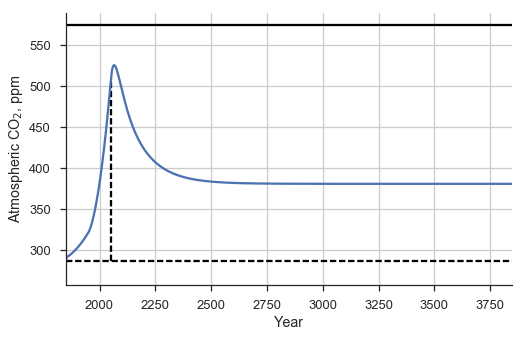

In [29]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

o.atm_ppm.plot(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Atmospheric CO$_2$, ppm")

CO2_0 = o.atm_ppm.iloc[0]
CO2_double = 2.*CO2_0
ax.hlines([CO2_0, CO2_double], 1850, 1850+2000,
          linestyles=['dashed', 'solid'])

## Doubling calculation
co2_inc = lambda x : np.interp(x, o.index, o.atm_ppm) - CO2_double
from scipy.optimize import newton
x_dbl2 = newton(co2_inc, 2100.)
ax.plot(x_dbl2, CO2_double, "dr", ms=10)
ax.vlines(x_dbl2, ax.get_ylim()[0], CO2_double)

ax.vlines(2050, CO2_0, np.interp(2050, o.index, o.atm_ppm), 
          linestyles='dashed')

ax.grid()
sns.despine()

print 
print "Doubling (initial) - ", x_dbl
print " Doubling (return) - ", x_dbl2
print "               Max - ", np.max(o.atm_ppm)
print "          Year Max - ", np.argmax(o.atm_ppm)

A few things are noteable about this graph.

1. Although the emissions begin to rapidly decay in 2050, the maximum atmospheric CO$_2$ (about 842 ppm) occurs two decades later in 2065).

2. To return to a state of doubled CO$_2$, it takes until 2229 - or 162 years after the maximum CO$_2$ is observed, and just shy of 180 years after emissions begin to reduce!

3. We ran the simulation for 2000 years, and it did not return to pre-industrial levels. In fact, it plateaued at about 500 ppm, but not until after 2500 - **700** years after the emissions began to ramp up.

4. Try running your simulation for 5000, 10000, or 50000 years (preferably with the reference numerical solver). In this model, the carbon sink from the atmosphere into all the other reservoirs is never enough to decrease the atmospheric CO$_2$ back to pre-industrial levels,  regardless of how long you let the model run.

---

### Part 3 | Model Application to Observed Atmospheric CO2 Concentrations

Finally, we'll apply our model to try to understand the 20th century atmospheric $\ce{CO2}$ record.

---

#### 3.1 - 20th Century Emissions

In [30]:
## Download the data, process separately
# 1) Land-use data
!wget http://cdiac.ornl.gov/trends/landuse/houghton/Global_land-use_flux-1850_2005.xls

# 2) Fossil-fuel data
!wget http://cdiac.ornl.gov/ftp/ndp030/CSV-FILES/global.1751_2010.csv

--2017-01-30 14:39:55--  http://cdiac.ornl.gov/trends/landuse/houghton/Global_land-use_flux-1850_2005.xls
Resolving cdiac.ornl.gov... 160.91.16.103
Connecting to cdiac.ornl.gov|160.91.16.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193024 (188K) [application/vnd.ms-excel]
Saving to: ‘Global_land-use_flux-1850_2005.xls.1’

100%[======================================>] 193,024     1.01MB/s   in 0.2s   

2017-01-30 14:39:55 (1.01 MB/s) - ‘Global_land-use_flux-1850_2005.xls.1’ saved [193024/193024]

--2017-01-30 14:39:55--  http://cdiac.ornl.gov/ftp/ndp030/CSV-FILES/global.1751_2010.csv
Resolving cdiac.ornl.gov... 160.91.16.103
Connecting to cdiac.ornl.gov|160.91.16.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6729 (6.6K) [text/csv]
Saving to: ‘global.1751_2010.csv.1’

100%[======================================>] 6,729       --.-K/s   in 0s      

2017-01-30 14:39:55 (126 MB/s) - ‘global.1751_2010.csv.1’ saved [6729/6729]



In [32]:
## Read in the data
# 1) Land-use data (TgC / year)
#    in Excel spreadsheet form, should be fine w/ pandas
lu_data = pd.read_excel("Global_land-use_flux-1850_2005.xls", 
                        sheetname="net fluxes", index_col=0)
# convert from TgC to PgC 
lu_data = lu_data*1e-3

#print lu_data.head()

# 2) Fossil-fuel data (million metric tons, which is one million 
#    megagrams or one teragram)
ff_data = pd.read_csv("global.1751_2010.csv", skiprows=[1,], 
                      index_col=0)
# convert to PgC
ff_data = ff_data*1e-3
#print ff_data.tail()

## 3) Collect into single dataframe
ff_col = 'Total carbon emissions from ' + \
         'fossil fuel consumption and ' + \
         'cement production (million '  + \
         'metric tons of C)'
ff_data.rename(columns={ff_col: 'fossil_fuel'}, inplace=True)
ff_series = ff_data['fossil_fuel']

lu_data.rename(columns={'Global': 'land_use'}, inplace=True)
lu_series = lu_data['land_use']

cdiac_data = pd.concat([lu_series, ff_series], axis=1)

## Some post-processing on the merged data
# a) interpolate linearly for any missing data
cdiac_data.interpolate(inplace=True)
# b) mask NaNs to 0
cdiac_data[np.isnan(cdiac_data)] = 0.

Interpolate the data using the various recommendations. We'll use PCHIP for the higher-order, piecewise-polynomial interpolation.

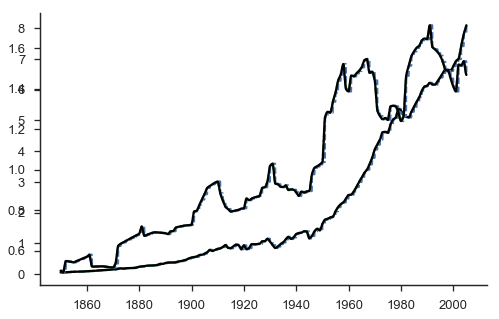

In [33]:
ts = np.linspace(1850, 2005, 12.*155 + 1.)

cx  = cdiac_data.index.values
lu = cdiac_data['land_use'].values
ff = cdiac_data['fossil_fuel'].values

fig = plt.figure(figsize=(8, 5))
plt.clf()
ax_ff = fig.add_subplot(111)
ax_lu = plt.twinx(ax=ax_ff)

## Base data
#cdiac_data['land_use'].plot(ax=ax_lu, linewidth=5)
#cdiac_data['fossil_fuel'].plot(ax=ax_ff, linewidth=5)
#ax.set_xlim(1850, 2005)

## 1) Constant for each year
def emis_cdiac_floor(t):
    t_base = int(np.floor(t))
    idx = t_base - cx[0]
    return 0., lu[idx], ff[idx]
yi = np.array([emis_cdiac_floor(t) for t in ts])
ax_lu.plot(ts, yi[:, 1], '--', label='LU - const')
ax_ff.plot(ts, yi[:, 2], '--', label='FF - const')

## 2) Linear interpolation
def emis_cdiac_linear(t):
    lu_int = np.interp(t, cx, lu)
    ff_int = np.interp(t, cx, ff)
    return 0., lu_int, ff_int
yi = np.array([emis_cdiac_linear(t) for t in ts])
ax_lu.plot(ts, yi[:, 1], '-.', label='LU - lin')
ax_ff.plot(ts, yi[:, 2], '-.', label='FF - lin')

## 3) PCHIP
from scipy.interpolate import PchipInterpolator
pchip_lu = PchipInterpolator(cx, lu)
pchip_ff = PchipInterpolator(cx, ff)
def emis_cdiac_pchip(t):
    return 0., pchip_lu(t), pchip_ff(t)
yi = np.array([emis_cdiac_pchip(t) for t in ts])
ax_lu.plot(ts, yi[:, 1], '-k', label='LU - pchip')
ax_ff.plot(ts, yi[:, 2], '-k', label='FF - pchip')

for i, x in enumerate([ax_lu, ax_ff]):
    ax.set_xlim(1980, 2000)
    ax.grid(False)
    if i == 1: ax.legend(loc='upper left')
sns.despine(fig)

**Note** - There's a caveat worth considering here with serious impacts when applying these techniques to true research. There are two ways to interpret the emissions data. On the one hand, we can simply view them as *intensities* or *instantaneous rates*. Under this interpretation, the interpolation techniques are valid in that we have a series of datapoints where an emissions intensity $E$ was observed at some point in time $t$, and we wish to re-construct the time-depended function $\hat{E}(t)$ based on the dataset $\{(t_i, E_i)\}$.

But there's a different way to look at the data which might be more relevant. In that case, the emissions data is **not** instaneous. Rather, its an aggregate of how much was emitted over a given time period (in this case, a one year interval). Under this schema, we can't merely interpolate the emissions intensities as before. Instead, we need to interpolate with the condition that the integral of the emissions curve over the periods of time between observations is conserved. That is, our curve connecting January 1, 2014 to January 1, 2015 needs to conform to the fact that, say, 10 PgC was emitted in that same interval of time. Now we have an additional problem of *non-uniqueness*; you could possibly imagine that there are infinite families of interpolating factions that could satisfy these constraints.

With our linearly-interpolated emissions data, let's try to simulate the observed CO$_2$ record.

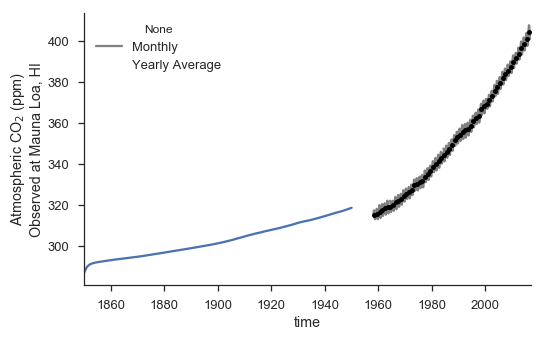

In [35]:
t_start = 1850
t_end = 1950
emis_wrap = lambda x: emis_cdiac_linear(t_start + x)

model = CarbonModel(*y0, emis_func=emis_wrap)
r = RK4Integrator()

o_spinup = model.integrate(r, t_end - t_start, dt=1.)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
mauna_loa_plot(ax)
o_spinup.atm_ppm.plot(ax=ax)

y_1950 = o_spinup.iloc[-1].values[:-4]

Feed in the results from the simulation to 1950 as the initial conditions for a simulation running from 1960 to 2013.

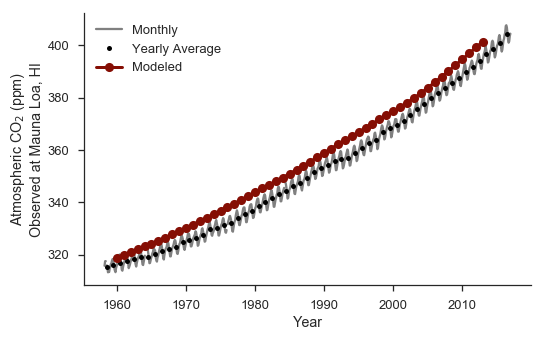

In [36]:
model = CarbonModel(*y_1950, emis_func=emis_wrap)
r = RK4Integrator()
t_start = 1960
t_end = 2013
o = model.integrate(r, t_end - t_start, dt=1.,
                    t_offset=t_start)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
mauna_loa_plot(ax)
ax.plot(o.index, o.atm_ppm,
        label='Modeled', marker='o',
        color=sns.xkcd_rgb['indian red'], 
        lw=3) 

o_cdiac = o.copy()

ax.legend(loc='upper left')

That's not a bad fit at all! Accounting for our slight difference in initial conditions, we capture a reasonable rate of increase for atmospheric $\ce{CO2}$, very much in line with the observational record. This is good evidence that our model does a reasonable job of reconciling the dynamics of the global carbon cycle - certainly well enough to dive deeper!

Repeat the previous exercise with the Global Carbon Budget dataset.

In [37]:
## Download the data
!wget ftp://cdiac.ornl.gov/pub/Global_Carbon_Project/Global_Carbon_Budget_2014_v1.0.xlsx

--2017-01-30 14:42:14--  ftp://cdiac.ornl.gov/pub/Global_Carbon_Project/Global_Carbon_Budget_2014_v1.0.xlsx
           => ‘Global_Carbon_Budget_2014_v1.0.xlsx.1’
Resolving cdiac.ornl.gov... 160.91.16.103
Connecting to cdiac.ornl.gov|160.91.16.103|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/Global_Carbon_Project ... done.
==> SIZE Global_Carbon_Budget_2014_v1.0.xlsx ... 512344
==> PASV ... done.    ==> RETR Global_Carbon_Budget_2014_v1.0.xlsx ... done.
Length: 512344 (500K) (unauthoritative)

100%[======================================>] 512,344     1.48MB/s   in 0.3s   

2017-01-30 14:42:15 (1.48 MB/s) - ‘Global_Carbon_Budget_2014_v1.0.xlsx.1’ saved [512344]



In [38]:
gcb = pd.read_excel("Global_Carbon_Budget_2014_v1.0.xlsx",
                    sheetname="Global Carbon Budget",
                    skiprows=19, index_col=0)
col_map = {
    'fossil fuel and cement emissions': 'fossil_fuel',
    'land-use change emissions': 'land_use',
}
gcb.rename(columns=col_map, inplace=True)

cx  = gcb.index.values
lu = gcb['land_use'].values
ff = gcb['fossil_fuel'].values

# Use a simple linear interpolation over the emissions data
def emis_gcb_linear(t):
    lu_int = np.interp(t, cx, lu)
    ff_int = np.interp(t, cx, ff)
    return 0., lu_int, ff_int

For quick reference, let's plot the GCB emissions data against the CDIAC emissions data:

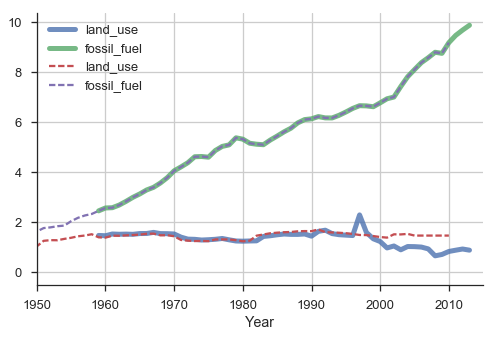

In [39]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
gcb[['land_use', 'fossil_fuel']]\
    .plot(ax=ax, 
          linewidth=5, alpha=0.8)
cdiac_data.plot(ax=ax, linestyle='dashed')

ax.set_xlim(1950, 2015)
ax.grid()
sns.despine()

There's not much of a difference, except the GCB data (in the solid colors) seems to capture a bit more nuance in the land-use budget after 1995. 

Using the Global Carbon Budget as our emissions, let's re-run the compartmental model from the branch-off point we previously used with CDIAC:

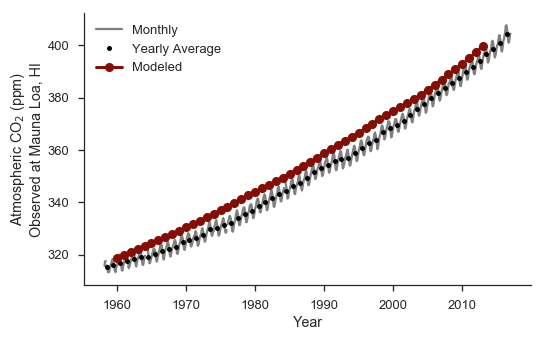

In [40]:
emis_gcb = lambda x: emis_gcb_linear(t_start + x)

## Run the model from the saved solution
#model = CarbonModel(*y_1950*0.995, emis_func=emis_gcb)
model = CarbonModel(*y_1950, emis_func=emis_gcb)
r = RK4Integrator()
t_start = 1960
t_end = 2013
o = model.integrate(r, t_end - t_start, dt=1.,
                    t_offset=t_start)
o_gcb = o.copy()

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
mauna_loa_plot(ax)
ax.plot(o.index, o.atm_ppm,
        label='Modeled', marker='o',
        color=sns.xkcd_rgb['indian red'], 
        lw=3) 

ax.legend(loc='upper left')

Once again, we very closely reproduce the observed record from Mauna Loa. In fact, we tend to improve the simulation post 1995 - we capture the rate of increase a bit more exactly, although in actuality we made only a modest tweak to the total emissions.

#### 3.2 - Looking Towards the Future

Now that we have some confidence in our model's ability to capture reality, let's apply it to understand something about future climate change. To do this, we'll use the "Representative Concentration Pathways" (RCP) which were previously used in the CMIP5 global climate model intercomparison. These RCPs are hypothetical scenarios describing how future greenhouse gas emissions might change. In a climate model, we'd use them as input to determine the atmospheric concentration in each year for use with the model's radiation module (with a caveat - some models have a global interactive carbon cycle, so in that case you'd use a slightly different formulation, but with the advantage of detecting feedbacks from that system).

For our purposes, let's just simulate how the emissions scenarios would matriculate into future $\ce{CO2}$ concentrations. We'll start by reading in the emissions scenarios and plotting them as before.

In [30]:
## Download the CMIP5 data
#!wget http://www.pik-potsdam.de/~mmalte/rcps/data/20THCENTURY_EMISSIONS.xls
#!wget http://www.pik-potsdam.de/~mmalte/rcps/data/RCP3PD_EMISSIONS.xls
#!wget http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_EMISSIONS.xls
#!wget http://www.pik-potsdam.de/~mmalte/rcps/data/RCP6_EMISSIONS.xls
#!wget http://www.pik-potsdam.de/~mmalte/rcps/data/RCP85_EMISSIONS.xls

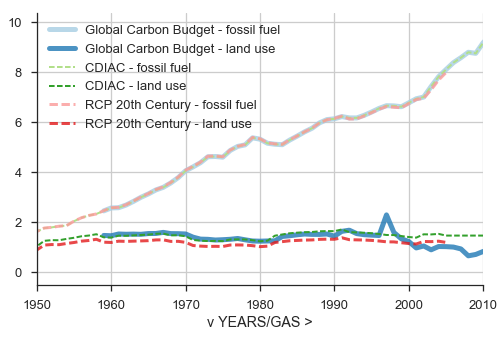

In [41]:
## Read in the 20th century emissions database, construct
## time-varying emissions function, and produce a simulation of
## the 20th century
rcp_20th = pd.read_excel("20THCENTURY_EMISSIONS.xls",
                         sheetname="20THCENTURY_EMISSIONS",
                         skiprows=36, index_col=0)
index_map = {"v YEARS/GAS >": "years", }
col_map = {"FossilCO2": "fossil_fuel", "OtherCO2": "land_use"}
rcp_20th.rename(index_map, col_map, inplace=True)

cx  = rcp_20th.index.values
lu = rcp_20th['land_use'].values
ff = rcp_20th['fossil_fuel'].values

def emis_rcp_20th_linear(t):
    lu_int = np.interp(t, cx, lu)
    ff_int = np.interp(t, cx, ff)
    return 0., lu_int, ff_int

split_str = lambda s : s.replace("_", " ")

with sns.color_palette('Paired'):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    for name, df, ls, lw, alpha in \
        [('Global Carbon Budget', gcb, 'solid', 5., 0.8),
         ('CDIAC', cdiac_data, '--', 2., 1.0),
         ('RCP 20th Century', rcp_20th, '--', 3., 0.8)]:
            
        for key in ["fossil_fuel", "land_use"]:
            df[key].plot(ax=ax, lw=lw, ls=ls, alpha=alpha,
                         label="%s - %s" % (name, split_str(key)))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(1950, 2010)
    sns.despine()

We notice that 20th Century RCP analysis slightly disagrees with both the CDIAC and GCB ones. However, the difference is enough that we might be interested in how this affects our simulation of 20th century atmospheric carbon dioxide, so we should plot up a quick comparison.

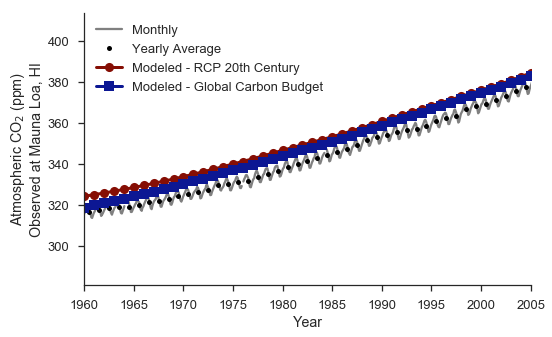

In [42]:
t_start = 1850
t_end = 2005

emis_rcp_20th = lambda x: emis_rcp_20th_linear(t_start + x)

## Run the model from the initial conditions
model = CarbonModel(*y0, emis_func=emis_rcp_20th)
r = RK4Integrator()

o = model.integrate(r, t_end - t_start, dt=1.,
                    t_offset=t_start)
o_rcp_20th = o.copy()

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
mauna_loa_plot(ax)
ax.plot(o_rcp_20th.index, o_rcp_20th.atm_ppm,
        label='Modeled - RCP 20th Century', marker='o',
        color=sns.xkcd_rgb['indian red'], 
        lw=3)
ax.plot(o_gcb.index, o_gcb.atm_ppm,
        label='Modeled - Global Carbon Budget', marker='s',
        color=sns.xkcd_rgb['royal'], 
        lw=3)

ax.set_xlim(1960, 2005)

ax.legend(loc='upper left')

y_rcp_2005 = o_rcp_20th.iloc[-1].values[:-4]

Actually, not much of a difference. 

--- 

** Projection of future climate change using RCP scenarios **

Now, let's simulate the future climate change scenarios defined by each RCP. This cell will combine everything we've done so far: loading in an emisisons dataset, converting it to a function, instantiating a model run, and running the model.

In [43]:
scenarios = { 
    "RCP3-PD": {
        'short': "RCP3PD", 
        "description": "Low RCP with pick and decline",
        "color": sns.xkcd_rgb['royal'],
    },
    "RCP4.5": { 
        'short': "RCP45",
        "description": "Medium-low RCP with stabilisation from 2150 onwards",
        "color": sns.xkcd_rgb['amber'],
    },
    "RCP6": {
        'short': "RCP6",
        "description": "Medium-high RCP with stabilisation from 2150 onwards",
        "color": sns.xkcd_rgb['steel grey'],
    }, 
    "RCP8.5": {
        'short': "RCP85",
        "description": "High RCP, stabilising emissions post-2100, concentrations post-2200",
        "color": sns.xkcd_rgb['lipstick red'],
    },
}

for rcp in scenarios.keys():
    print rcp, scenarios[rcp]['description']
    
    ## Read emissions
    short = scenarios[rcp]['short']
    rcp_emis = pd.read_excel("%s_EMISSIONS.xls" % short,
                             sheetname="%s_EMISSIONS" % short,
                             skiprows=37, index_col=0)
    index_map = {"v YEARS/GAS >": "years", }
    col_map = {"FossilCO2": "fossil_fuel", "OtherCO2": "land_use"}
    rcp_emis.rename(index_map, col_map, inplace=True)
    scenarios[rcp]['emissions'] = rcp_emis
    
    ## Linearly interpolate emissions
    cx  = rcp_emis.index.values
    lu = rcp_emis['land_use'].values
    ff = rcp_emis['fossil_fuel'].values

    def emis_rcp_linear(t):
        lu_int = np.interp(t, cx, lu)
        ff_int = np.interp(t, cx, ff)
        return 0., lu_int, ff_int
    
    scenarios[rcp]['emissions_interp'] = emis_rcp_linear

    ## Run and save model outpu
    t_start, t_end = 1850, 2500

    emis_rcp_wrap = lambda x: emis_rcp_linear(t_start + x)

    ## Run the model from the initial conditions
    model = CarbonModel(*y0, emis_func=emis_rcp_wrap)
    r = RK4Integrator()
    o = model.integrate(r, t_end - t_start, dt=0.25,
                        t_offset=t_start)
    scenarios[rcp]['output'] = o.copy()

RCP8.5 High RCP, stabilising emissions post-2100, concentrations post-2200
RCP4.5 Medium-low RCP with stabilisation from 2150 onwards
RCP3-PD Low RCP with pick and decline
RCP6 Medium-high RCP with stabilisation from 2150 onwards


Plot the results, adding some useful details to the figure.

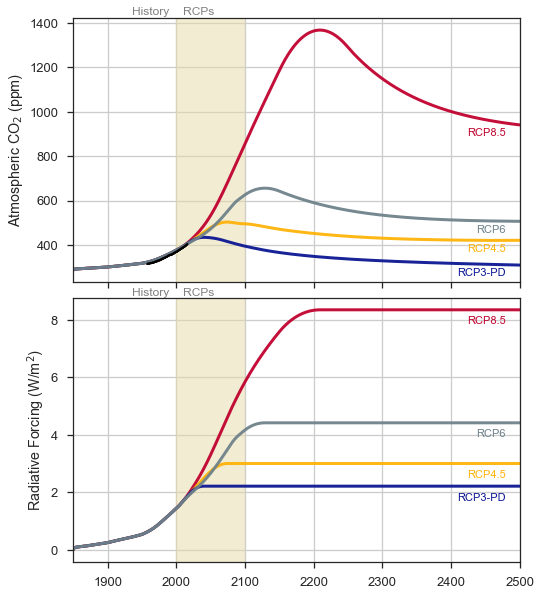

In [44]:
fig, [ax_CO2, ax_RF] = plt.subplots(2, 1, figsize=(8, 10),
                                    sharex=True)
plt.subplots_adjust(hspace=0.06)

for rcp in scenarios.keys():
    output = scenarios[rcp]['output']
    color = scenarios[rcp]['color']
    
    output.atm_ppm.plot(ax=ax_CO2, color=color,
                        lw=3, alpha=0.95, label=rcp)
    ax_CO2.text(2480, output.atm_ppm.ix[2500]-50., rcp,
            color=color, ha='right', size=11)
    mauna_loa_yearly.average.plot(ax=ax_CO2, color='k')
        
    
    delta_F = 5.35*np.log(output.atm_ppm/output.atm_ppm.ix[1850])
    idx_max = np.argmax(delta_F)
    delta_F.ix[idx_max:] = delta_F.ix[idx_max]
    delta_F.plot(ax=ax_RF, color=color, lw=3, alpha=0.95,
                 label=rcp)
    ax_RF.text(2480, delta_F.ix[2500]-0.5, rcp,
               color=color, ha='right', size=11)
    
ax_CO2.set_ylabel("Atmospheric CO$_2$ (ppm)")
ax_RF.set_ylabel("Radiative Forcing (W/m$^2$)")

    
for ax in [ax_CO2, ax_RF]:
    ax.grid()
    ax.set_xlabel("")
    
    # RCP vs observations annotation
    ax.axvspan(2000, 2100, color=sns.xkcd_rgb['beige'],
               alpha=0.5)
    ax.text(1990, ax.get_ylim()[1]*1.01, "History", color='grey',
            ha='right')
    ax.text(2010, ax.get_ylim()[1]*1.01, "RCPs", color='grey',
            ha='left')

This plot is similar to what's on the RCP website. For simplicity, I froze the radiative forcing plots at their maximum values.

There are many clear implications of these simulations. For starters, the high-emissions scenario produce a significant amount of radiative forcing up to and beyond the year 2100. This would have substantial impacts on our global climate - including significant warming in the global average. The radiative equivalent of doubling $\ce{CO2}$ is about 4 degrees per watt per meter-squared. For a rough and dirty calculation, in the RCP8.5 case, this would yield a little more than 6 degrees of warming in equilibrium. That's *a lot*!

Of course, this neglects many things. For instance, what might happen to the carbon cycle in a warming climate? Consider the land-use budget we use in our emissions. Although de-forestation is a major component of it, shifts in precipitation and temperature could also affect the type and presence of vegetation in many places around the world. If precipitation were to drastically decrease in a region that otherwise would experience a large amount on average, significant loss of vegetation could occur and affect the magnitude of the global carbon sink. In that sense, there would be a *positive feedback* on climate change - the shrinking of the carbon sink as the world warms would, on average, tend to increase the rate of increase of carbon in the atmosphere, producing even more warming. Constraining the magnitude of global carbon cycle feedbacks is a major contemporary research issue, and some modern global models even include detailed carbon cycle models (much more so than what we've done here - real models coupled to the chemistry and biology of the oceans and land surface) to reconcile these effects.